In [1]:
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from matplotlib import ticker
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator
from arch import arch_model
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from pandas.plotting import table

In [2]:
plt.rcParams.update({
    'axes.titlecolor': '#2C3E50',        
    'axes.labelsize': 12,
    'axes.labelcolor': '#2C3E50',        
    'xtick.color': '#2C3E50',             
    'ytick.color': '#2C3E50',             
    'font.family': 'Arial',            
    'figure.titlesize': 16,
    'figure.titleweight': 'semibold',
})

In [3]:
start_date = "2024-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

In [4]:
file_path = "/Users/hanyuyang/Downloads/gold_spot_price_20230101-20250220_day.xlsx"
gold_data = pd.read_excel(file_path, sheet_name=0)
gold_data.rename(columns={'date': 'Date'}, inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data.set_index('Date', inplace=True)
gold_data = gold_data.loc['2024-01-01':]

In [5]:
# Fetch macroeconomic data from FRED
def fetch_macro_data():
    fred = Fred(api_key="2568a56e45cf1b9a1039cfcdb88b4bd3")
    start_date = "2024-01-01"
    end_date = datetime.today().strftime('%Y-%m-%d')
    
    cpi = fred.get_series("CPIAUCSL", observation_start=start_date, observation_end=end_date)
    treasury_yield = fred.get_series("DGS10", observation_start=start_date, observation_end=end_date)
    t10y2y = fred.get_series("T10Y2Y", observation_start=start_date, observation_end=end_date)
    
    # Resample to daily frequency and forward fill missing values
    cpi = cpi.resample("D").ffill().dropna()
    treasury_yield = treasury_yield.resample("D").ffill().dropna()
    t10y2y = t10y2y.resample("D").ffill().dropna()

    macro_df = pd.DataFrame({
        "CPI": cpi,
        "10Y_Treasury": treasury_yield,
        "T10Y2Y": t10y2y
    })
    
    return macro_df


In [6]:
# Fetch market data from Yahoo Finance
def get_yahoo_data():
    DX = yf.download("DX-Y.NYB", start=start_date, end=end_date)
    VIX = yf.download("^VIX", start=start_date, end=end_date)
    SP500 = yf.download("^GSPC", start=start_date, end=end_date)
    
    DX.index = pd.to_datetime(DX.index)
    VIX.index = pd.to_datetime(VIX.index)
    SP500.index = pd.to_datetime(SP500.index)

    yahoo_df = pd.DataFrame(index=DX.index)
    yahoo_df["US Index"] = DX["Close"]
    yahoo_df["VIX"] = VIX["Close"]
    yahoo_df["S&P500"] = SP500["Close"]
    
    # Forward-fill any missing values
    yahoo_df = yahoo_df.ffill()
    return yahoo_df

if __name__ == "__main__":
    macro_data = fetch_macro_data()
    yahoo_data = get_yahoo_data()
    
    merged_df = gold_data.join(macro_data, how="outer").ffill()
    data = merged_df.join(yahoo_data, how="outer").ffill()

    print(data.head())

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

               Open     High      Low     Close      CPI  10Y_Treasury  \
2024-01-01      NaN      NaN      NaN       NaN  309.794           NaN   
2024-01-02  2062.65  2078.69  2055.99  2058.739  309.794          3.95   
2024-01-03  2058.59  2065.89  2030.45  2040.990  309.794          3.91   
2024-01-04  2041.05  2050.69  2036.09  2042.990  309.794          3.99   
2024-01-05  2042.99  2063.79  2024.29  2045.500  309.794          4.05   

            T10Y2Y    US Index    VIX       S&P500  
2024-01-01     NaN         NaN    NaN          NaN  
2024-01-02   -0.38  102.199997  13.20  4742.830078  
2024-01-03   -0.42  102.459999  14.04  4704.810059  
2024-01-04   -0.39  102.419998  14.13  4688.680176  
2024-01-05   -0.35  102.410004  13.35  4697.240234  


In [7]:
# Calculate technical indicators
def calculate_technical_indicators(df):
    close = df['Close']
    
    # 20-day Simple Moving Average
    df['SMA20'] = SMAIndicator(close, window=20).sma_indicator()
    
    # Bollinger Bands with a 20-day window and 2 standard deviations
    bb = BollingerBands(close, window=20, window_dev=2)
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    
    # MACD
    macd = MACD(close)
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_hist'] = macd.macd_diff()
    
    # RSI with a period of 14
    df['RSI'] = RSIIndicator(close).rsi()
    
    return df

data = calculate_technical_indicators(data)
print(data.head())

               Open     High      Low     Close      CPI  10Y_Treasury  \
2024-01-01      NaN      NaN      NaN       NaN  309.794           NaN   
2024-01-02  2062.65  2078.69  2055.99  2058.739  309.794          3.95   
2024-01-03  2058.59  2065.89  2030.45  2040.990  309.794          3.91   
2024-01-04  2041.05  2050.69  2036.09  2042.990  309.794          3.99   
2024-01-05  2042.99  2063.79  2024.29  2045.500  309.794          4.05   

            T10Y2Y    US Index    VIX       S&P500  SMA20  BB_upper  BB_lower  \
2024-01-01     NaN         NaN    NaN          NaN    NaN       NaN       NaN   
2024-01-02   -0.38  102.199997  13.20  4742.830078    NaN       NaN       NaN   
2024-01-03   -0.42  102.459999  14.04  4704.810059    NaN       NaN       NaN   
2024-01-04   -0.39  102.419998  14.13  4688.680176    NaN       NaN       NaN   
2024-01-05   -0.35  102.410004  13.35  4697.240234    NaN       NaN       NaN   

            MACD  MACD_signal  MACD_hist  RSI  
2024-01-01   NaN    

/var/folders/3p/hmw7bpz157732w2fln0dwgp40000gn/T/ipykernel_92705/894614042.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


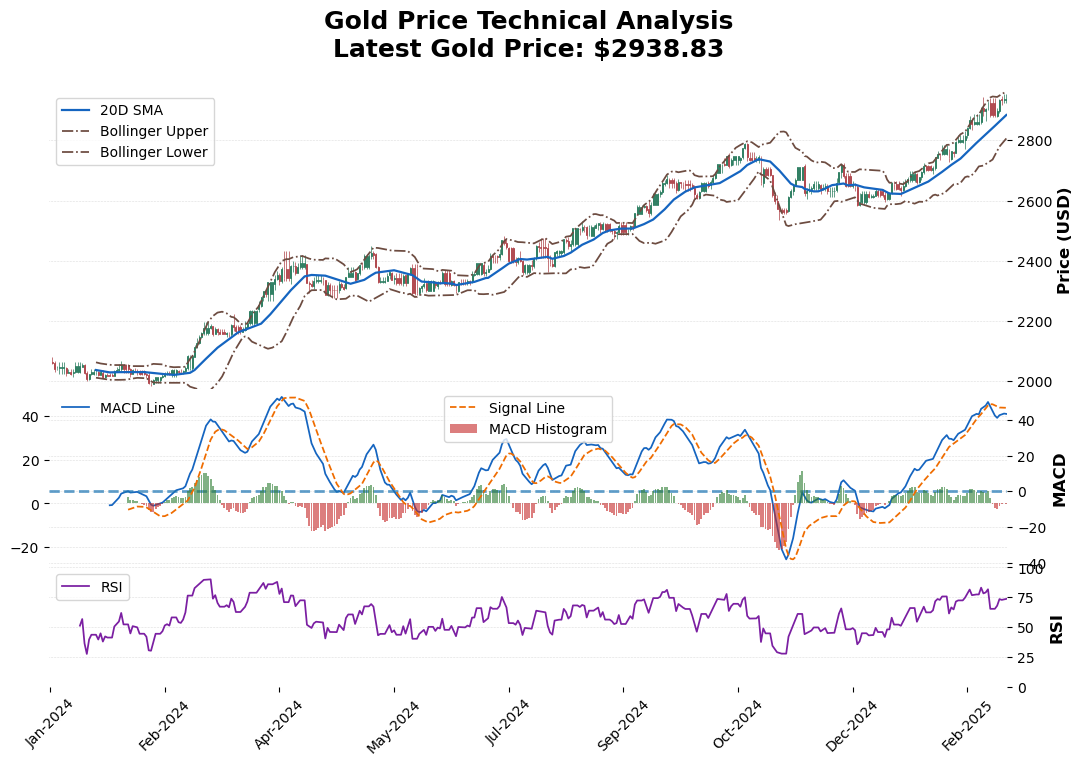

In [8]:
plt.style.use('seaborn')
plt.rcParams.update({
    'font.family': 'Arial',
    'figure.figsize': (20, 18), 
    'figure.dpi': 120,
    'grid.alpha': 0.3,
    'axes.titlecolor': 'black',
    'axes.labelcolor': '#333333',
    'xtick.color': '#333333',
    'ytick.color': '#333333',
    'figure.facecolor': '#f5f5f5'
})

COLOR_SCHEME = {
    'candle_up': '#2e7d32',
    'candle_down': '#c62828',
    'sma': '#1565C0',
    'bollinger': '#6d4c41',
    'macd': '#1565C0',
    'signal': '#EF6C00',
    'rsi': '#7B1FA2'
}

apds = [
    mpf.make_addplot(data['SMA20'], 
                    color=COLOR_SCHEME['sma'], 
                    width=1.6,
                    panel=0,
                    label='20D SMA'),   
    
    mpf.make_addplot(data['BB_upper'], 
                    color=COLOR_SCHEME['bollinger'], 
                    linestyle='-.',
                    panel=0,
                    label='Bollinger Upper'),   
    
    mpf.make_addplot(data['BB_lower'], 
                    color=COLOR_SCHEME['bollinger'], 
                    linestyle='-.',
                    panel=0,
                    label='Bollinger Lower'),  

    mpf.make_addplot(data['MACD'], 
                    color=COLOR_SCHEME['macd'],
                    panel=1,
                    ylabel='MACD',
                    label='MACD Line'),       
    
    mpf.make_addplot(data['MACD_signal'], 
                    color=COLOR_SCHEME['signal'],
                    linestyle='--',
                    panel=1,
                    label='Signal Line'),    
    
    mpf.make_addplot(data['MACD_hist'], 
                    type='bar',
                    color=np.where(data['MACD_hist'] >=0, 
                                COLOR_SCHEME['candle_up'], 
                                COLOR_SCHEME['candle_down']),
                    alpha=0.6,
                    panel=1,
                    label='MACD Histogram'),   

    mpf.make_addplot(data['RSI'], 
                    color=COLOR_SCHEME['rsi'],
                    panel=2,
                    ylabel='RSI',
                    ylim=(0, 100),
                    label='RSI')              
]

fig, axes = mpf.plot(
    data,
    type='candle',
    style='charles',
    ylabel='Price (USD)',
    volume=False, 
    addplot=apds,
    panel_ratios=(5, 3, 2), 
    figratio=(16, 10),
    returnfig=True,
    datetime_format='%b-%Y',
    figscale=1.2,
    tight_layout=True
)

# Dynamic title with latest price
latest_price = data['Close'].iloc[-1]
latest_date = data.index[-1].strftime('%Y-%m-%d')
axes[0].set_title('Gold Price Technical Analysis', fontsize=16, pad=20, color='#1F77B4')
axes[0].set_title(f'Gold Price Technical Analysis\nLatest Gold Price: ${latest_price:.2f}', 
                 fontsize=18, pad=25, color='black', fontweight='bold')

# Remove all borders and configure grid
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, axis='y', color='#666666', linestyle=':', alpha=0.4)
    ax.grid(False, axis='x')
    ax.set_facecolor('white')

# RSI panel enhancements
axes[2].axhline(0, color='#1F77B4', linestyle='--', alpha=0.7)
axes[2].legend(['MACD', 'Signal Line'], loc='upper left', fontsize=9)

# Legend customization
axes[1].legend(loc='upper left', frameon=False, fontsize=10)
axes[2].legend(loc='upper left', frameon=False, fontsize=10)

fig.autofmt_xdate(rotation=0, ha='right')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [9]:
data = data.sort_index()

data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['Rolling_STD'] = data['Close'].rolling(window=20).std()

atr_indicator = AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=14)
data['ATR'] = atr_indicator.average_true_range()


/var/folders/3p/hmw7bpz157732w2fln0dwgp40000gn/T/ipykernel_92705/4002245879.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


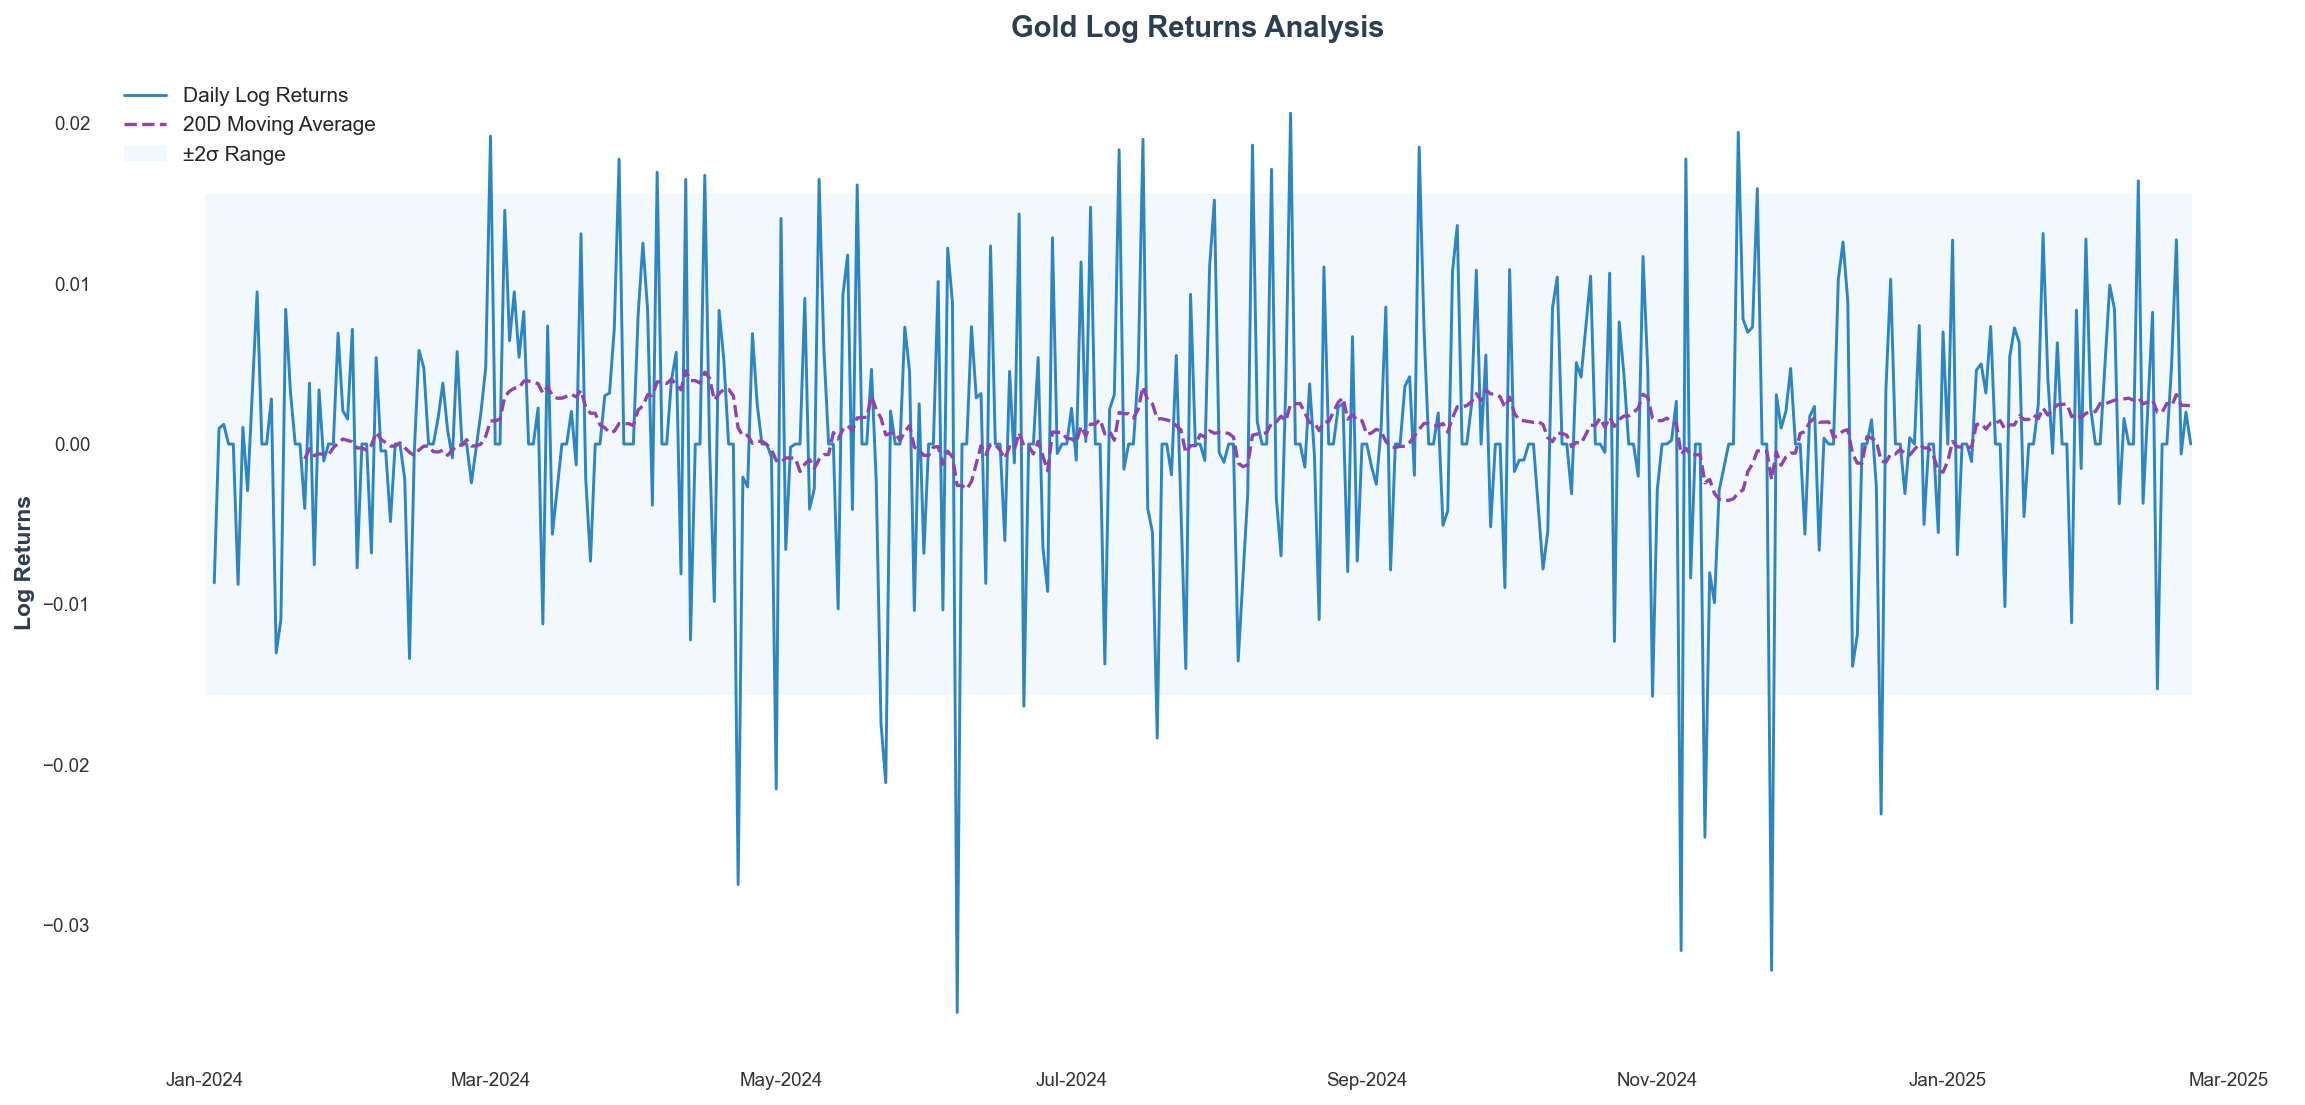

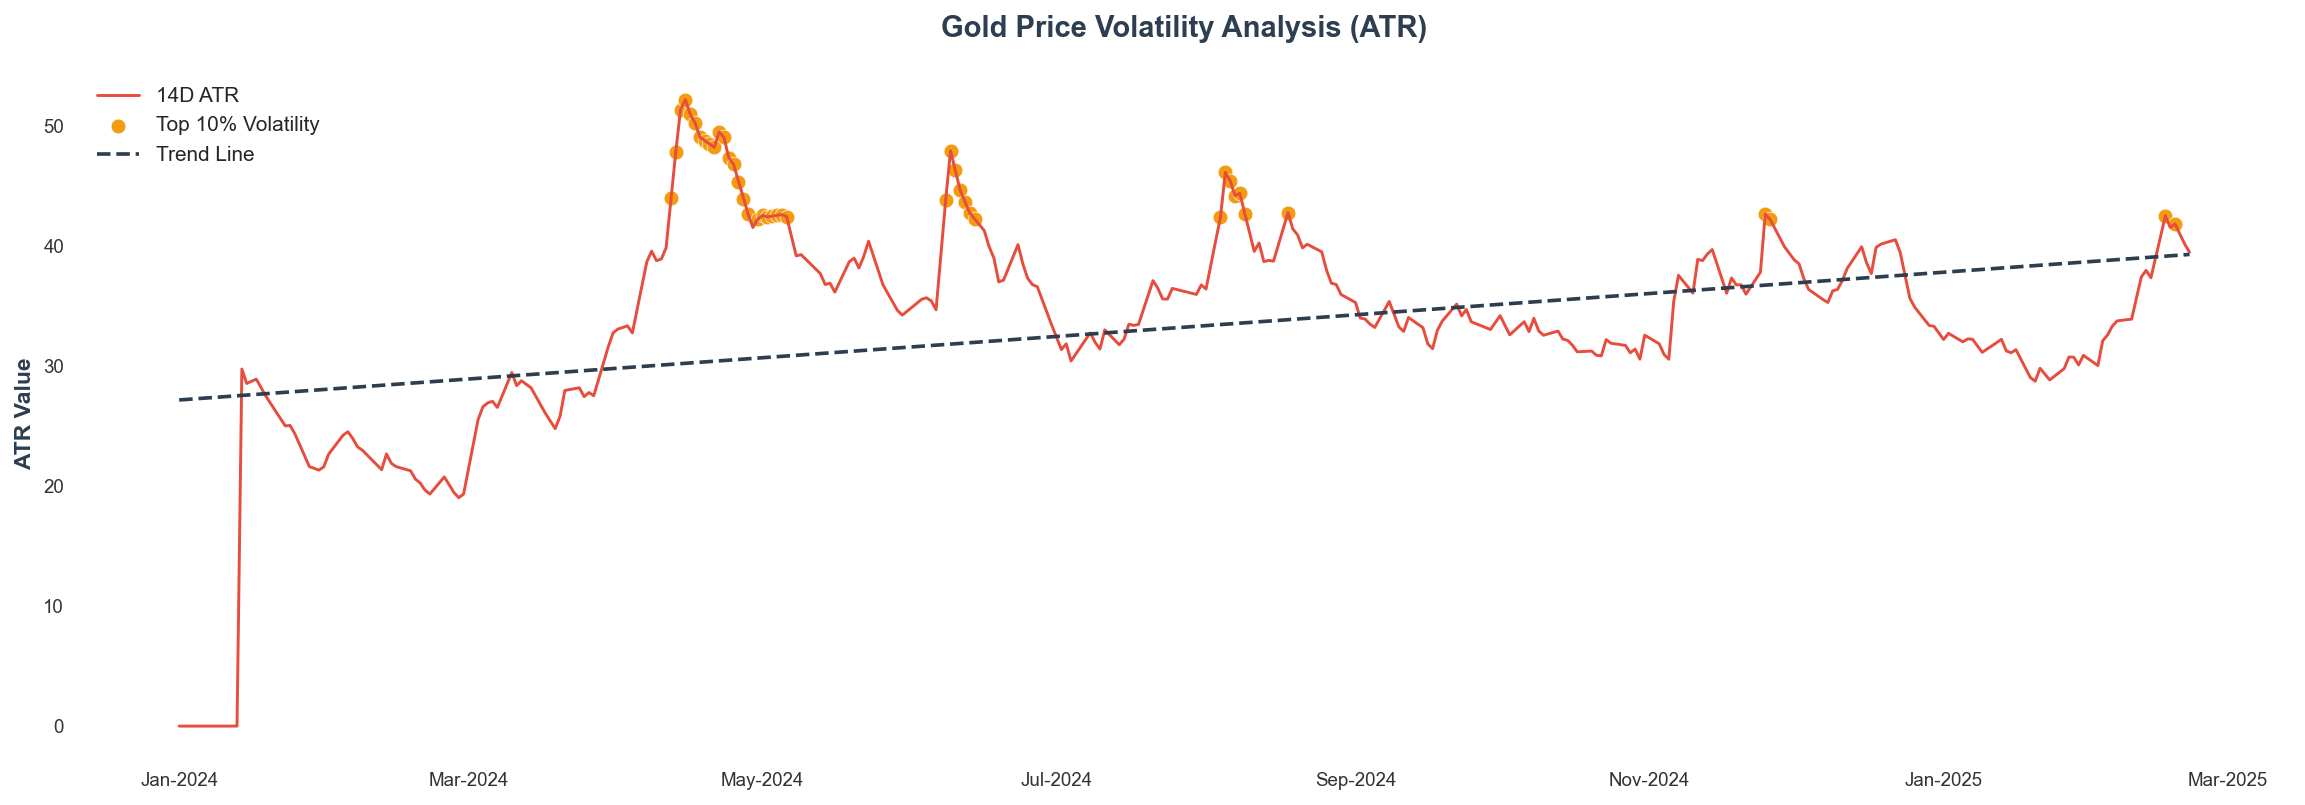

In [16]:
#Log Returns 
plt.style.use('seaborn')
plt.rcParams.update({
    'font.family': 'Arial',
    'axes.titlesize': 14,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'figure.dpi': 150,
    'figure.facecolor': 'none',
    'axes.facecolor': 'none',
    'axes.edgecolor': '#333333',  
    'xtick.color': '#333333',      
    'ytick.color': '#333333'      
})

fig1 = plt.figure(figsize=(16, 8), facecolor='none')
ax1 = fig1.add_subplot(111)

ma_window = 20
data['LogRet_MA'] = data['Log_Returns'].rolling(ma_window).mean()

latest_price = data['Close'].iloc[-1]
latest_date = data.index[-1].strftime('%Y-%m-%d')

ax1.plot(data.index, data['Log_Returns'], 
        color='#2E86C1',
        lw=1.4,
        label='Daily Log Returns')
ax1.plot(data.index, data['LogRet_MA'], 
       color='#8E44AD',
       linestyle='--',
       lw=1.6,
       label='20D Moving Average')
ax1.fill_between(data.index, -2*data['Log_Returns'].std(), 2*data['Log_Returns'].std(),
               color='#AED6F1', alpha=0.15, label='±2σ Range')

ax1.set_title(f'Gold Log Returns Analysis',
            color='#2C3E50', 
            weight='semibold',
            pad=15)
ax1.set_ylabel('Log Returns', color='#2C3E50')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks()
ax1.spines[['top', 'right']].set_visible(False)
ax1.spines[['bottom', 'left']].set_color('#2C3E50') 
ax1.legend(frameon=False, loc='upper left')
plt.tight_layout(pad=3)
plt.show()

#ATR 
fig2 = plt.figure(figsize=(16, 6), facecolor='none')
ax2 = fig2.add_subplot(111)

ax2.plot(data.index, data['ATR'], 
        color='#E74C3C',
        lw=1.4,
        label='14D ATR')
ax2.scatter(data[data['ATR'] > data['ATR'].quantile(0.9)].index,
          data['ATR'][data['ATR'] > data['ATR'].quantile(0.9)],
          color='#F39C12',
          s=50,
          edgecolor='white',
          label='Top 10% Volatility')
ax2.plot(data.index, np.polyval(np.polyfit(np.arange(len(data)), data['ATR'], 1), np.arange(len(data))),
       color='#2C3E50',
       linestyle='--',
       label='Trend Line')

ax2.set_title('Gold Price Volatility Analysis (ATR)', 
            color='#2C3E50',
            weight='semibold',
            pad=15)
ax2.set_ylabel('ATR Value', color='#2C3E50')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks()
ax2.spines[['top', 'right']].set_visible(False)
ax2.spines[['bottom', 'left']].set_color('#2C3E50') 
ax2.legend(frameon=False, loc='upper left')
plt.tight_layout(pad=3)
plt.show()

In [11]:
returns = data['Log_Returns'].dropna() * 100

garch_model = arch_model(returns, vol='Garch', p=1, q=1, dist='Normal')
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

data['GARCH_vol'] = np.nan
data.loc[returns.index, 'GARCH_vol'] = garch_fit.conditional_volatility



                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -482.171
Distribution:                  Normal   AIC:                           972.343
Method:            Maximum Likelihood   BIC:                           988.466
                                        No. Observations:                  416
Date:                Sat, Feb 22 2025   Df Residuals:                      415
Time:                        22:14:36   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0799  3.763e-02      2.124  3.367e-02 [6.172e-0

/var/folders/3p/hmw7bpz157732w2fln0dwgp40000gn/T/ipykernel_92705/3104510324.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


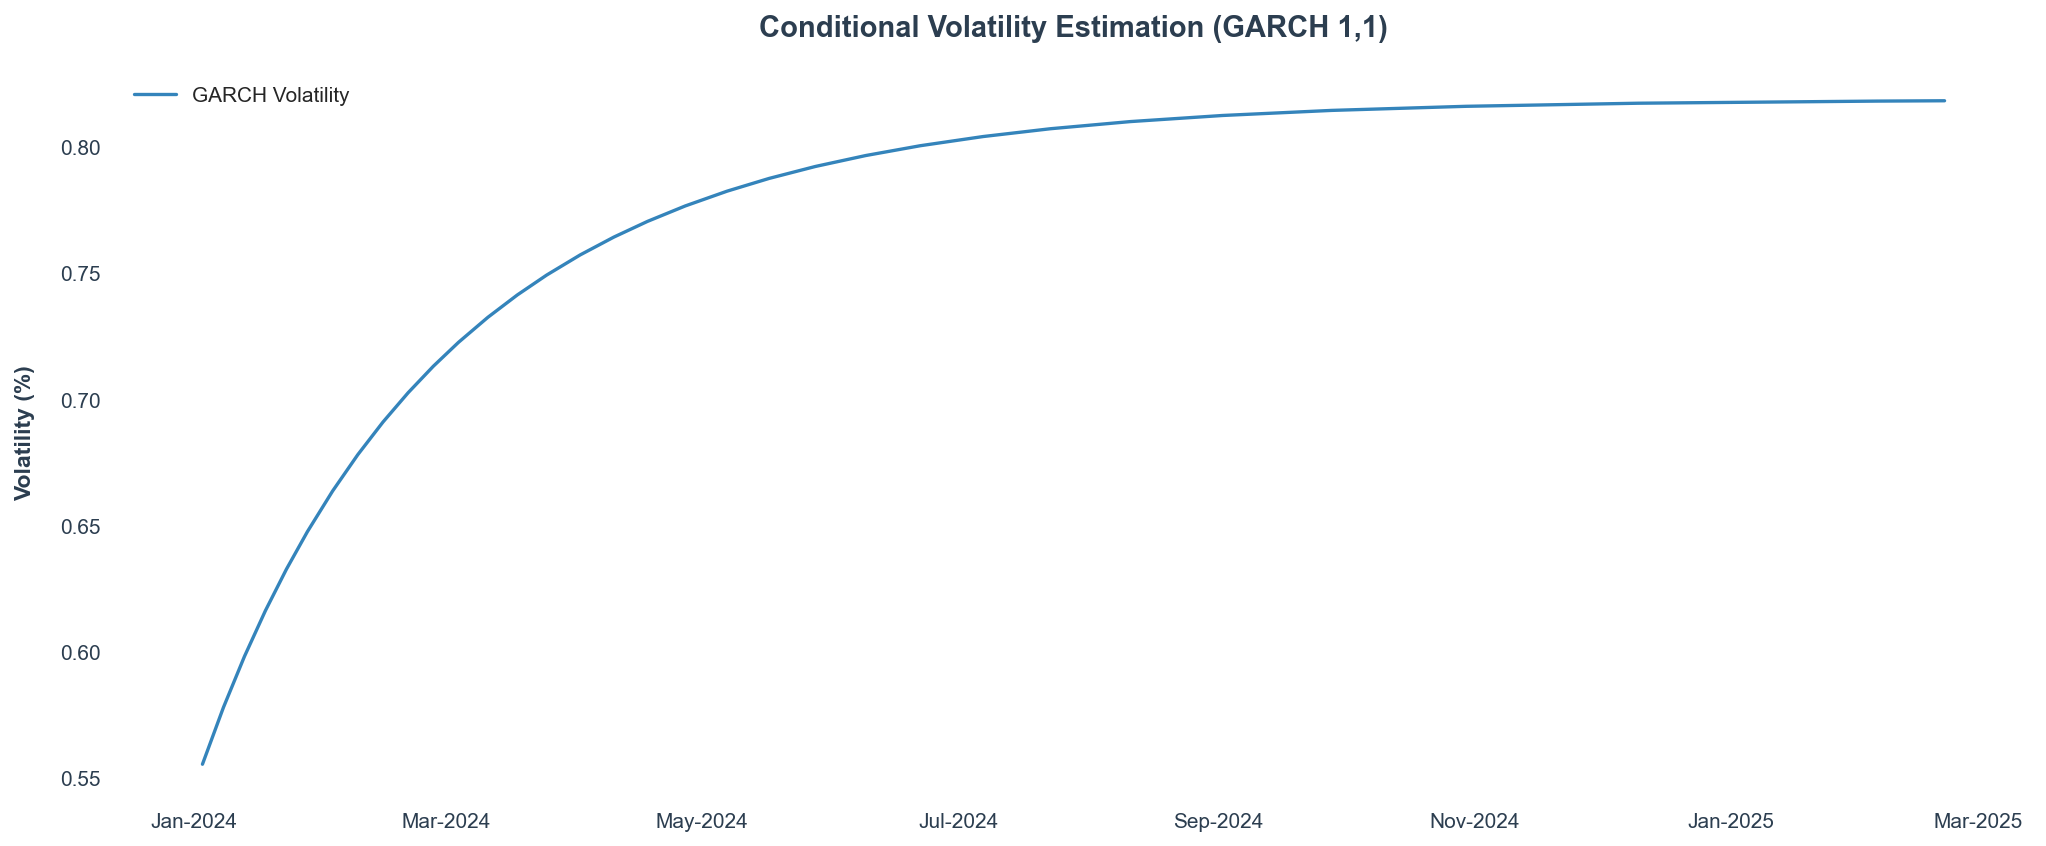

In [12]:
plt.style.use('seaborn')
plt.rcParams.update({
    'axes.titlecolor': '#2C3E50',
    'axes.labelcolor': '#2C3E50',
    'xtick.color': '#2C3E50',
    'ytick.color': '#2C3E50',
    'figure.facecolor': 'none',
    'axes.facecolor': 'none'
})

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data.index, data['GARCH_vol'], 
       label='GARCH Volatility', 
       color='#1F77B4',
       lw=1.6,
       alpha=0.9)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks()

ax.set_title('Conditional Volatility Estimation (GARCH 1,1)', 
           fontsize=14,
           pad=15,
           color='#2C3E50',
           weight='semibold')
ax.set_ylabel('Volatility (%)', color='#2C3E50', labelpad=12)

ax.legend(frameon=False, loc='upper left', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['left'].set_color('#CCCCCC')

plt.tight_layout(pad=2.0)
plt.show()

/var/folders/3p/hmw7bpz157732w2fln0dwgp40000gn/T/ipykernel_92705/4002408617.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


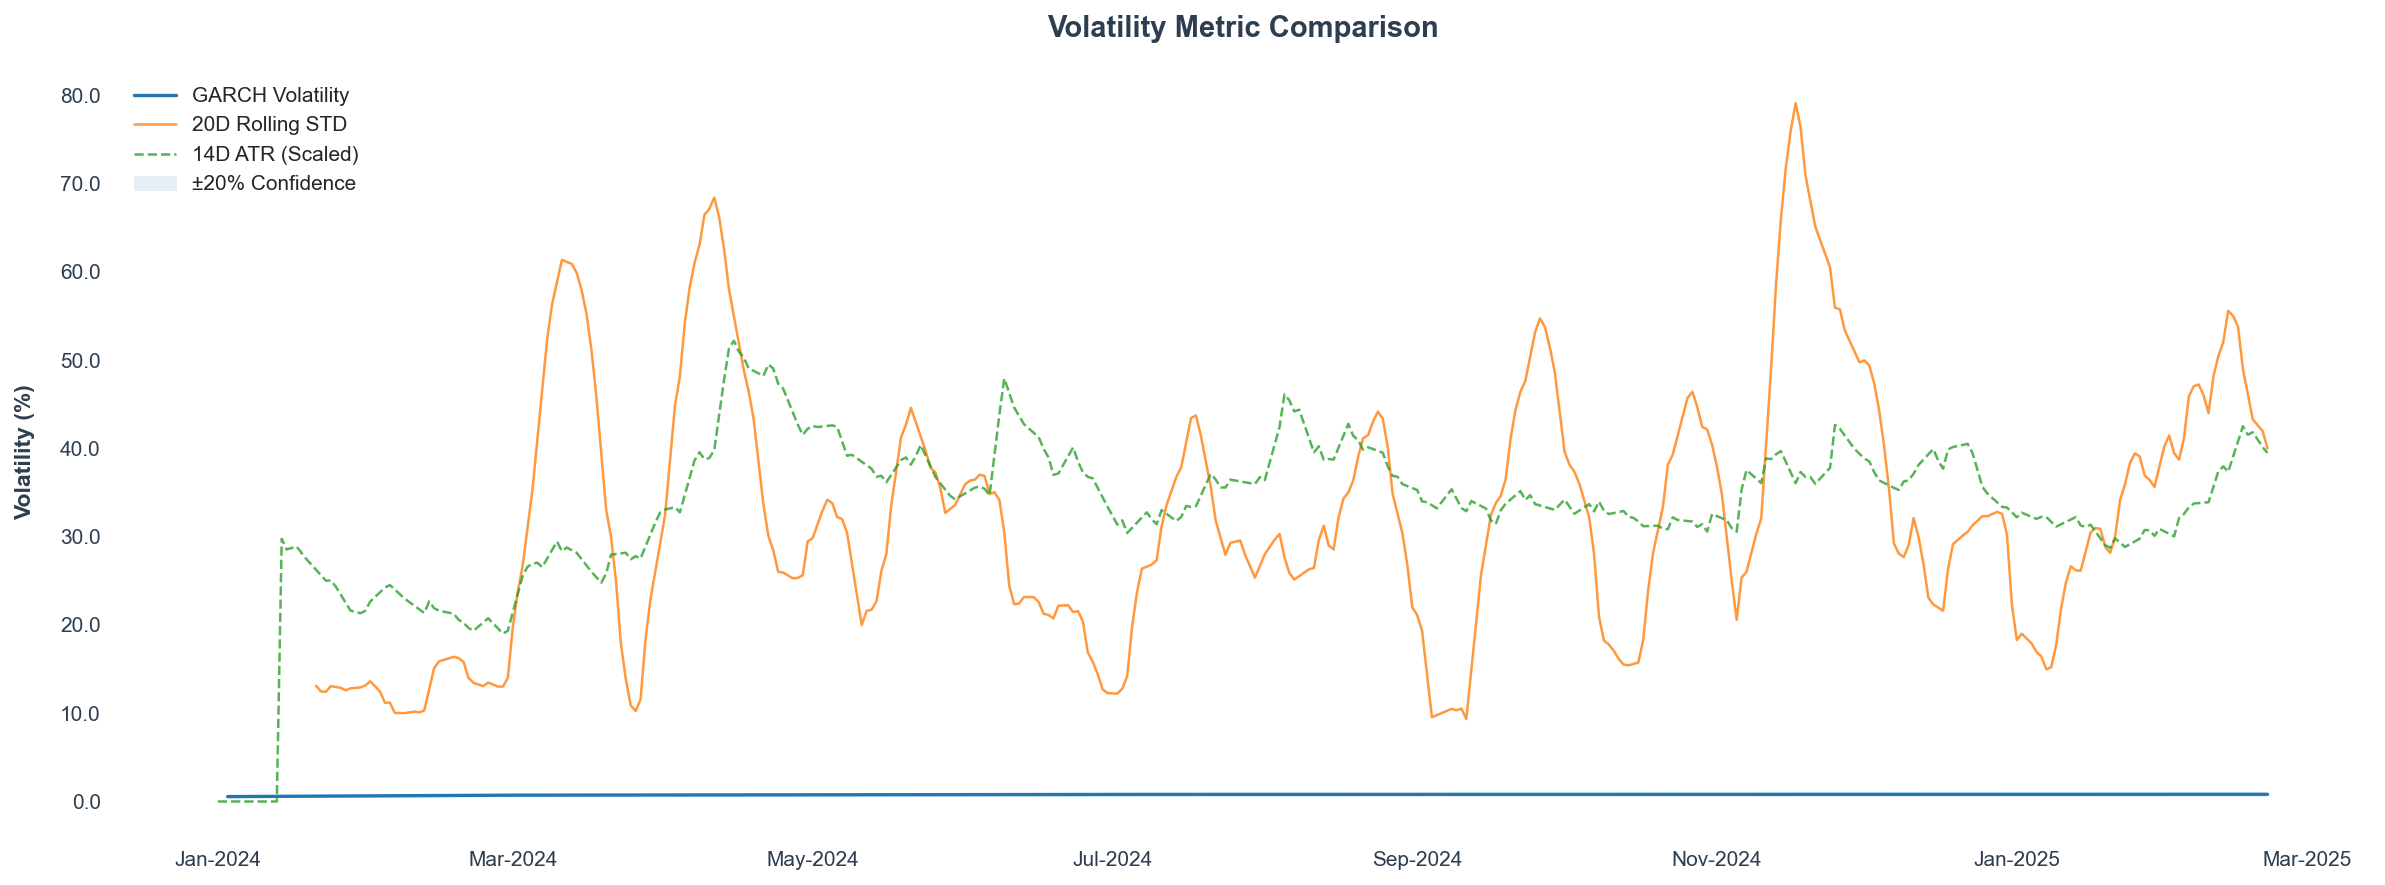

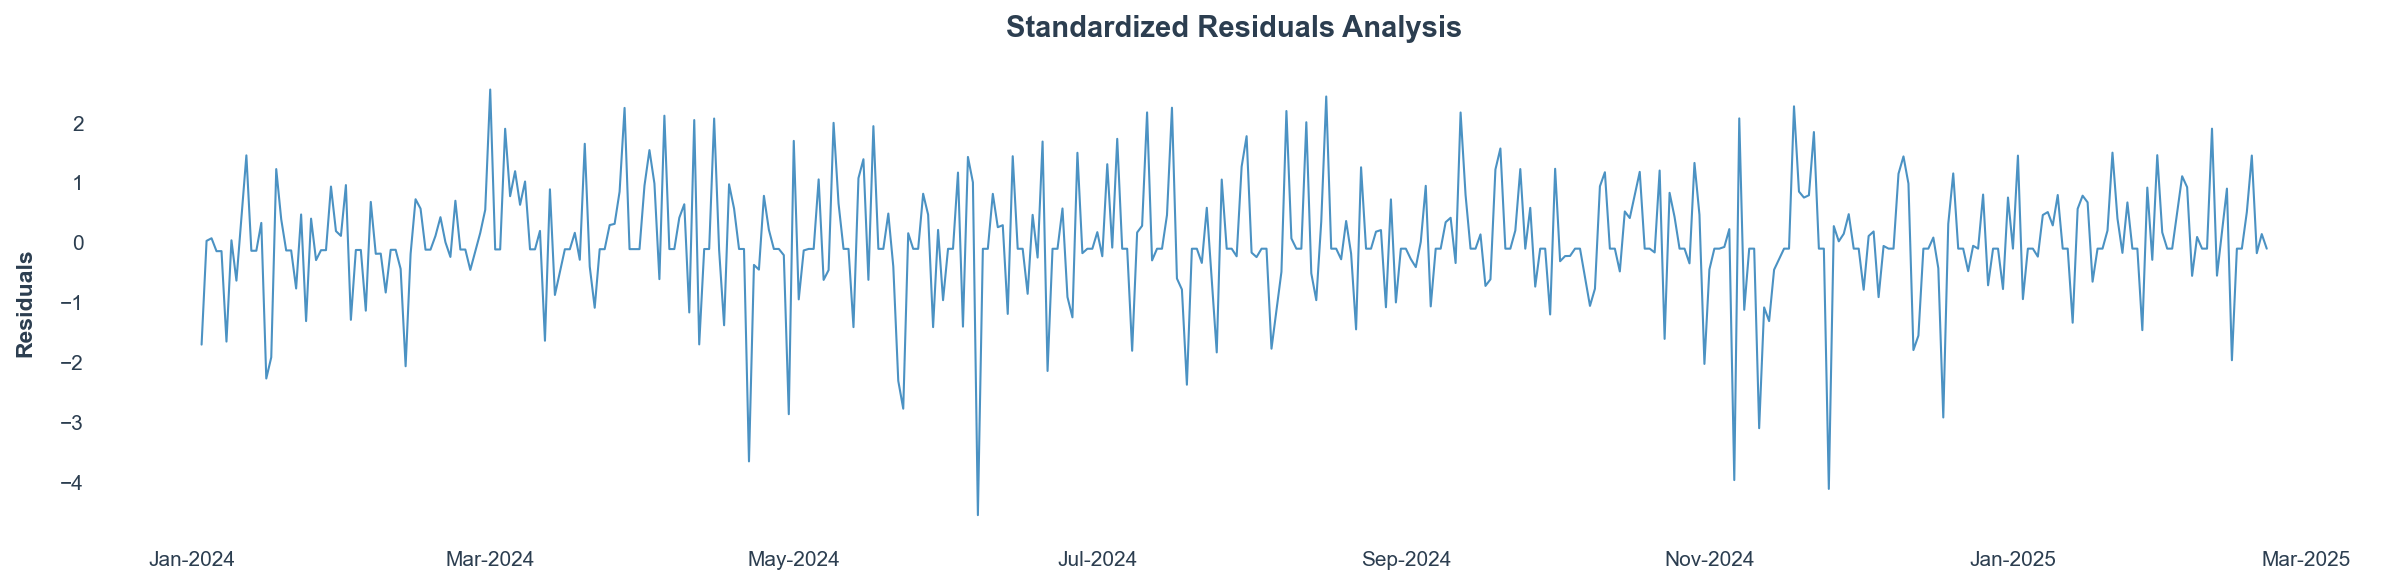

In [13]:
# Volatility
plt.style.use('seaborn')
plt.rcParams.update({
    'axes.titlecolor': '#2C3E50',
    'axes.labelcolor': '#2C3E50',
    'xtick.color': '#2C3E50',
    'ytick.color': '#2C3E50',
    'figure.facecolor': 'none',
    'axes.facecolor': 'none' 
})

fig1 = plt.figure(figsize=(16, 6), facecolor='none')
ax_vol = fig1.add_subplot(111)
 
vol_line = ax_vol.plot(data.index, data['GARCH_vol'], 
                     color='#1F77B4',
                     lw=1.6,
                     label='GARCH Volatility')[0]

ax_vol.plot(data.index, data['Rolling_STD'], 
          color='#FF7F0E', 
          alpha=0.8,
          lw=1.2,
          label='20D Rolling STD')

ax_vol.plot(data.index, data['ATR'], 
          color='#2CA02C', 
          alpha=0.8,
          lw=1.2,
          linestyle='--',
          label='14D ATR (Scaled)')
 
ax_vol.fill_between(data.index,
                  data['GARCH_vol']*0.8,
                  data['GARCH_vol']*1.2,
                  color='#1F77B4',
                  alpha=0.12,
                  label='±20% Confidence')
 
ax_vol.set_title('Volatility Metric Comparison', 
               fontsize=14, 
               pad=15,
               color='#2C3E50',
               weight='semibold')
ax_vol.set_ylabel('Volatility (%)', labelpad=12)
ax_vol.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
 
ax_vol.legend(loc='upper left', frameon=False, fontsize=10)
ax_vol.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax_vol.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax_vol.tick_params()
plt.tight_layout()
plt.show()

#Residuals
fig2 = plt.figure(figsize=(16, 4), facecolor='none')
ax_resid = fig2.add_subplot(111)
 
residuals = garch_fit.resid / garch_fit.conditional_volatility
ax_resid.plot(residuals, 
            color='#1F77B4',
            alpha=0.8,
            lw=1.0)
 
ax_resid.set_title('Standardized Residuals Analysis', 
                 fontsize=14,
                 pad=15,
                 color='#2C3E50',
                 weight='semibold')
ax_resid.set_ylabel('Residuals', labelpad=12)

ax_resid.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax_resid.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax_resid.tick_params()
plt.tight_layout()
plt.show()


In [14]:
independent_vars = ['CPI', '10Y_Treasury', 'T10Y2Y', 'US Index','VIX', 'S&P500']
corr = data[['Close'] + independent_vars].corr()

X = data[independent_vars]
X = sm.add_constant(X)
y = data['Close']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1119.
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          1.17e-250
Time:                        22:14:36   Log-Likelihood:                -2293.0
No. Observations:                 417   AIC:                             4600.
Df Residuals:                     410   BIC:                             4628.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.557e+04   1433.524    -10.861   

/var/folders/3p/hmw7bpz157732w2fln0dwgp40000gn/T/ipykernel_92705/3588921822.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


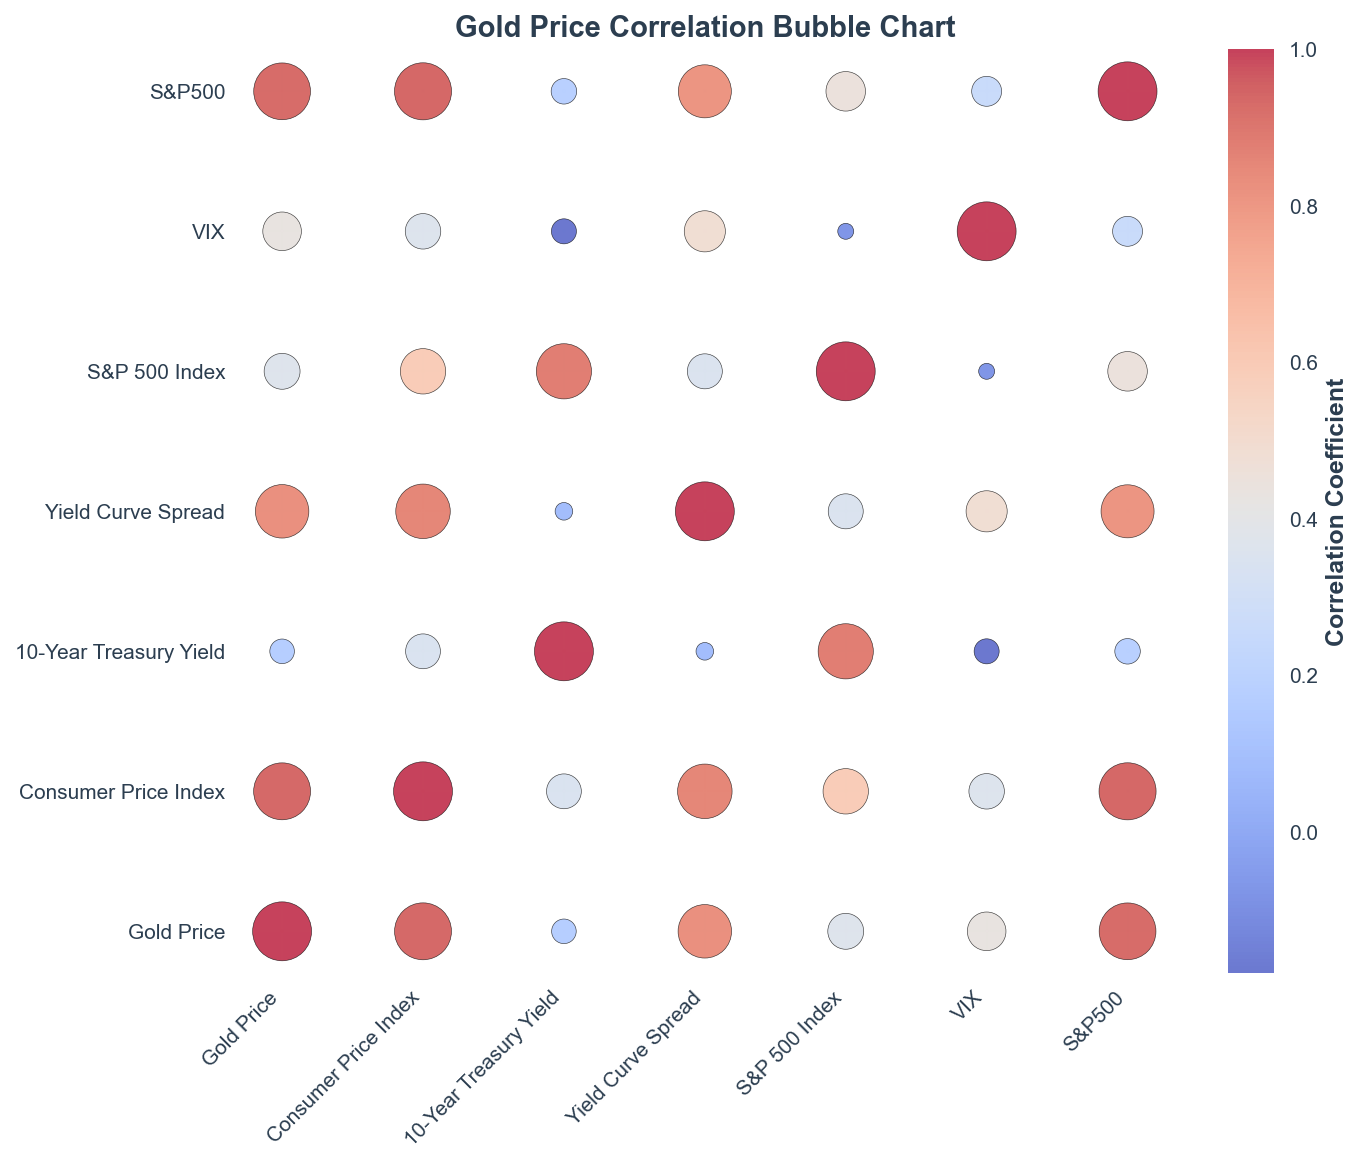

/var/folders/3p/hmw7bpz157732w2fln0dwgp40000gn/T/ipykernel_92705/3588921822.py:116: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_rolling_correlations({
/var/folders/3p/hmw7bpz157732w2fln0dwgp40000gn/T/ipykernel_92705/3588921822.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize_regression(model, X, data['Close']).show()


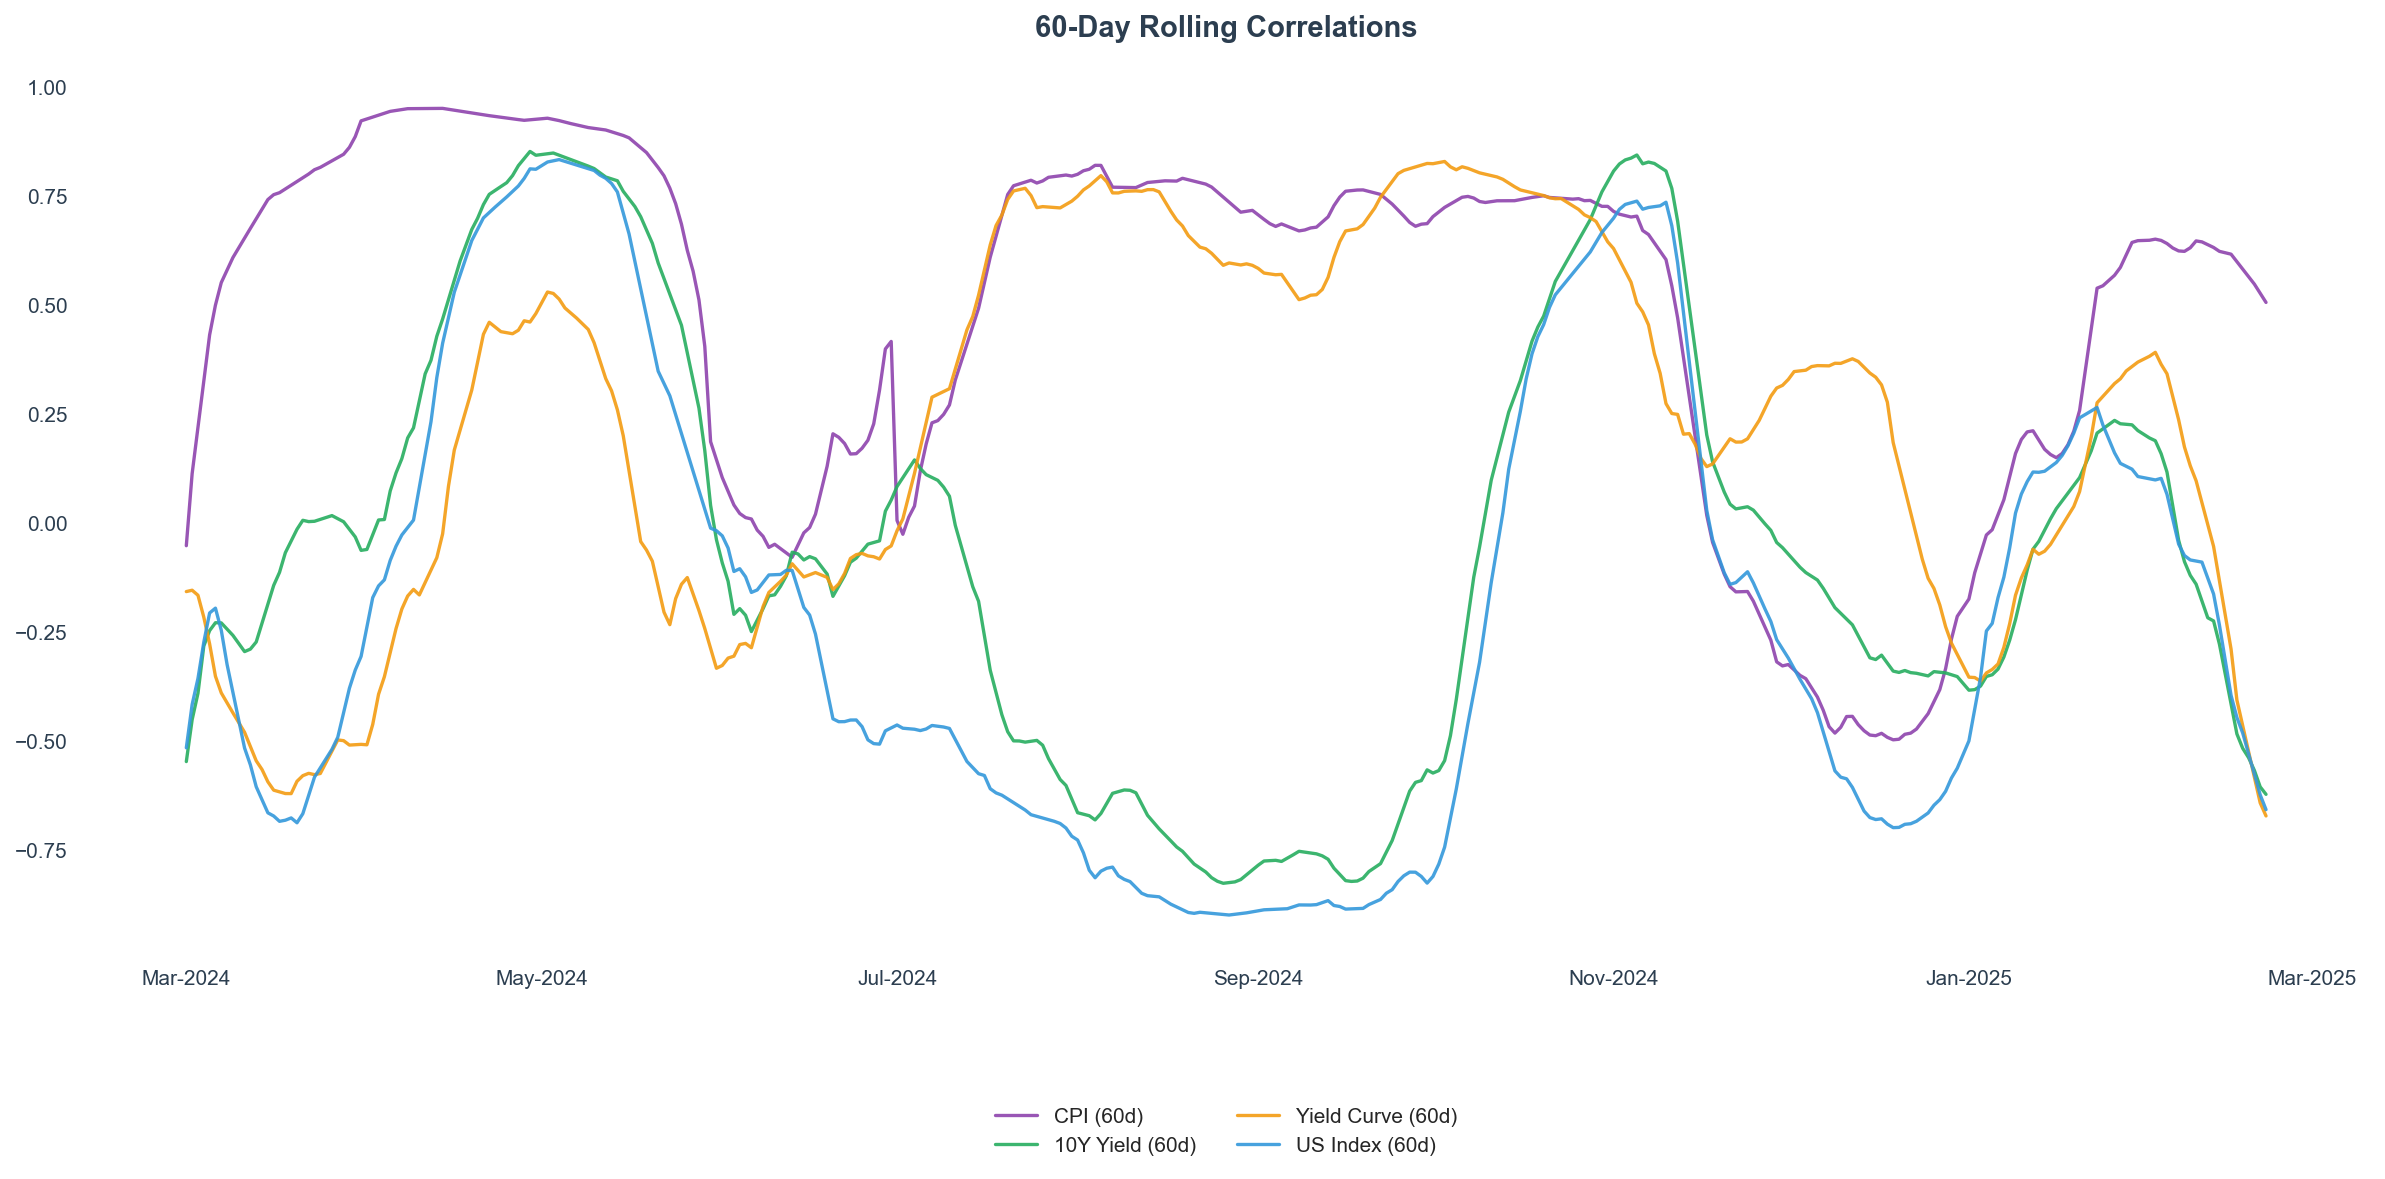

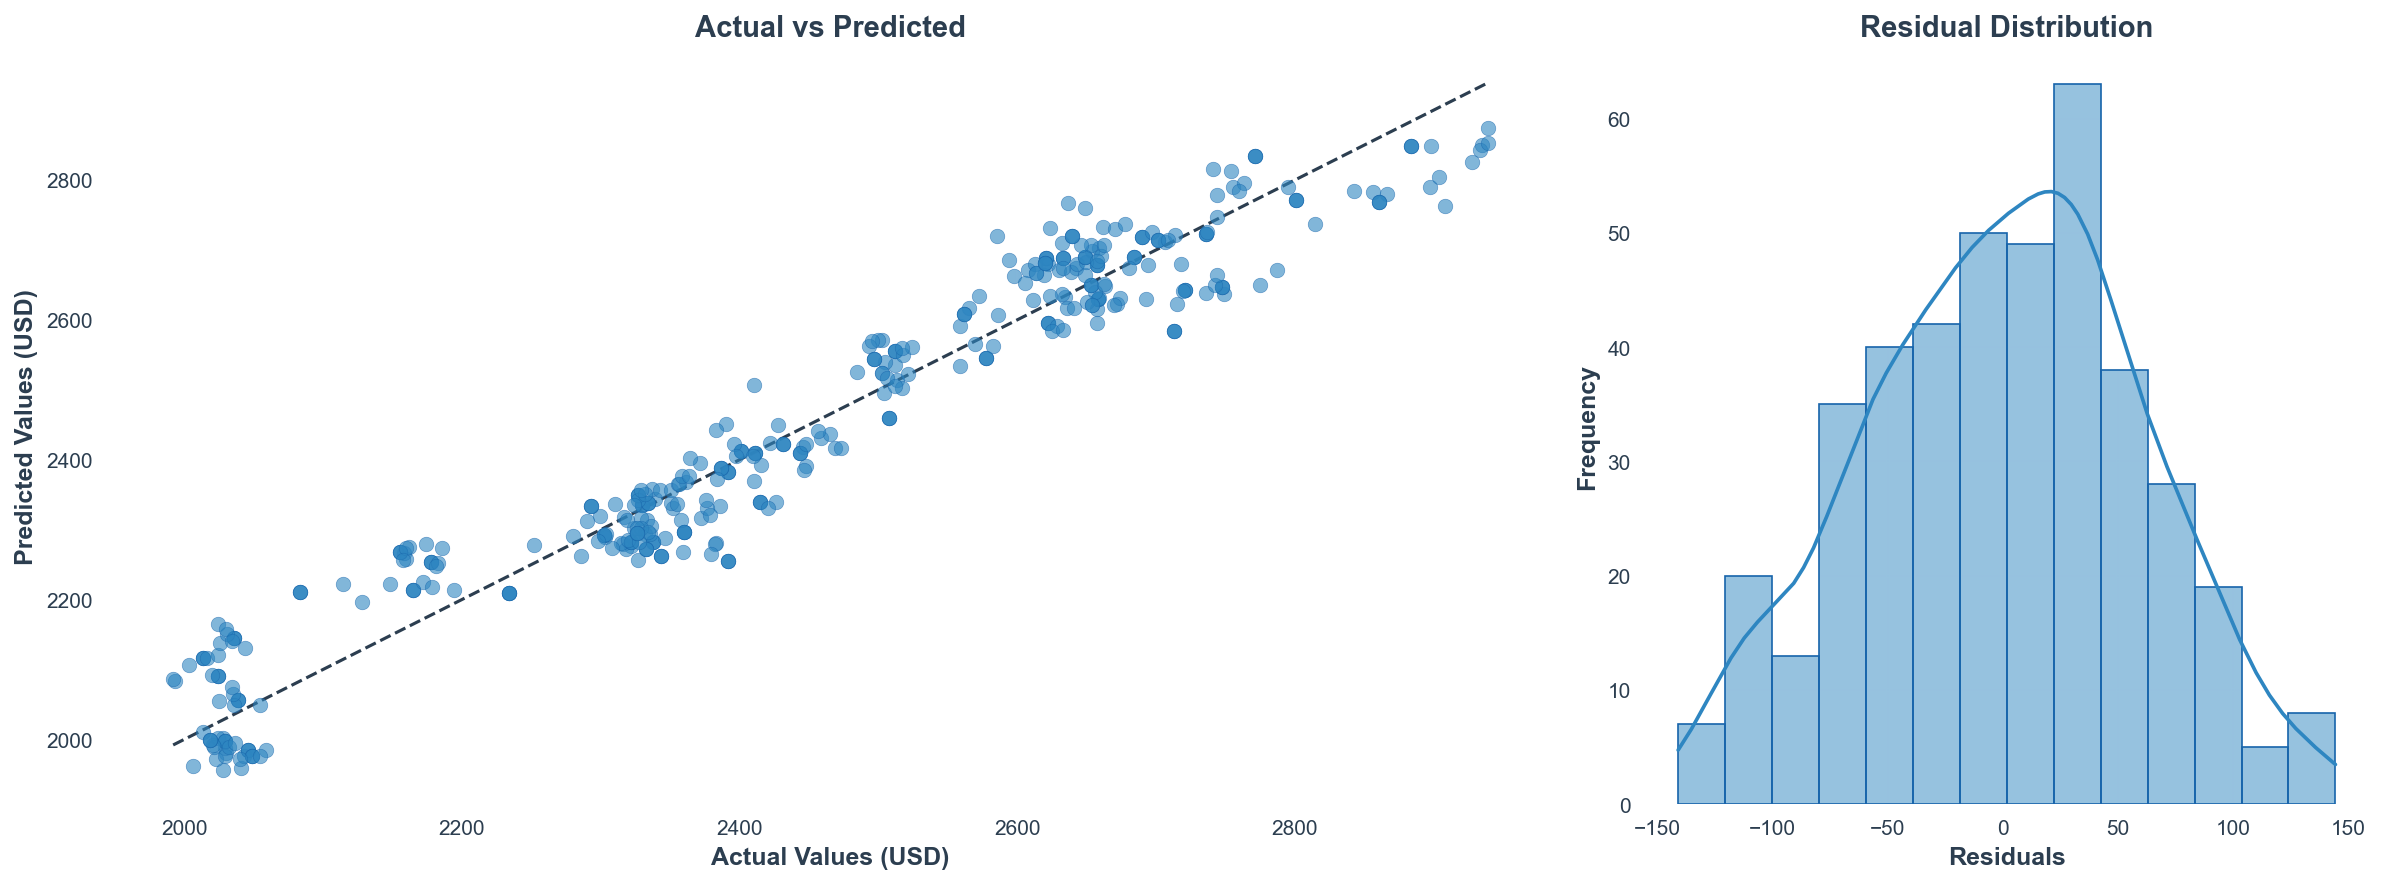

In [15]:
plt.style.use('seaborn')
plt.rcParams.update({
    'font.family': 'Arial',
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 150,
    'figure.facecolor': 'none',
    'axes.facecolor': 'none',
    'grid.alpha': 0.3,
    'axes.titlecolor': '#2C3E50',
    'axes.labelcolor': '#2C3E50',
    'xtick.color': '#2C3E50',
    'ytick.color': '#2C3E50'
})

CORRELATION_COLORS = {
    'bubble': ['#2E86C1', '#FFFFFF'],
    'rolling_lines': ['#8E44AD', '#27AE60', '#F39C12', '#3498DB'],
    'regression': '#2E86C1',
    'sentiment': ['#16A085', '#D35400']
}

def plot_correlation_bubble_chart(corr_matrix, title, rename_dict=None):
    if rename_dict:
        corr_matrix = corr_matrix.rename(columns=rename_dict, index=rename_dict)

    fig, ax = plt.subplots(figsize=(10, 8))
    corr_matrix = corr_matrix.stack().reset_index()
    corr_matrix.columns = ['Variable 1', 'Variable 2', 'Correlation']

    bubble = ax.scatter(
        corr_matrix['Variable 1'], corr_matrix['Variable 2'],
        s=abs(corr_matrix['Correlation']) * 800,
        c=corr_matrix['Correlation'],
        cmap='coolwarm', edgecolors='black', alpha=0.75
    )
    
    plt.xticks(rotation=45, ha='right')
    plt.colorbar(bubble, label="Correlation Coefficient")
    ax.set_title(title, fontsize=14, weight='semibold')
    plt.show()

rename_dict = {
    'CPI': 'Consumer Price Index',
    '10Y_Treasury': '10-Year Treasury Yield',
    'T10Y2Y': 'Yield Curve Spread',
    'US Index': 'S&P 500 Index',
    'Close': 'Gold Price'
}

corr = data[['Close'] + independent_vars].corr()
plot_correlation_bubble_chart(corr, "Gold Price Correlation Bubble Chart", rename_dict)

def plot_rolling_correlations(data_dict, window=60):
    fig = plt.figure(figsize=(16, 8), facecolor='none')
    ax = fig.add_subplot(111)
    
    line_styles = ['-', '--', '-.', ':']
    
    for idx, (label, series) in enumerate(data_dict.items()):
        ax.plot(
            series.index,
            series,
            color=CORRELATION_COLORS['rolling_lines'][idx],
            linestyle=line_styles[idx // 4],
            lw=1.6 - 0.2*(idx//4),
            alpha=0.9,
            label=f'{label} ({window}d)'
        )
    
    ax.set_title(f"{window}-Day Rolling Correlations", fontsize=14, pad=15, weight='semibold')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
    ax.spines['bottom'].set_color('#2C3E50')
    ax.spines['left'].set_color('#2C3E50')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.spines[['top', 'right']].set_visible(False)
    plt.xticks()
    plt.tight_layout()
    return fig

def visualize_regression(model, X, y):
    fig = plt.figure(figsize=(16, 6), facecolor='none')
    gs = GridSpec(1, 2, width_ratios=[2, 1])
    
    ax1 = fig.add_subplot(gs[0])
    pred = model.predict(X)
    ax1.scatter(y, pred, 
               color=CORRELATION_COLORS['regression'],
               alpha=0.6, 
               edgecolor=plt.cm.Blues(0.8),
               marker='o',
               zorder=3)
    ax1.plot([y.min(), y.max()], [y.min(), y.max()], '--', lw=1.5, color='#2C3E50')
    ax1.set_xlabel("Actual Values (USD)")
    ax1.set_ylabel("Predicted Values (USD)")
    
    ax2 = fig.add_subplot(gs[1])
    residuals = y - pred
    sns.histplot(residuals, kde=True, color=CORRELATION_COLORS['regression'], edgecolor=plt.cm.Blues(0.8), linewidth=0.8)
    ax2.set_xlabel("Residuals")
    ax2.set_ylabel("Frequency")
    
    for ax, title in zip([ax1, ax2], ['Actual vs Predicted', 'Residual Distribution']):
        ax.set_title(title, fontsize=14, weight='semibold')
        ax.spines['bottom'].set_color('#2C3E50')
        ax.spines['left'].set_color('#2C3E50')
        ax.spines[['top', 'right']].set_visible(False)
        ax.tick_params(axis='both', colors='#2C3E50')
    
    plt.tight_layout()
    return fig

plot_rolling_correlations({
    'CPI': data['Close'].rolling(60).corr(data['CPI']),
    '10Y Yield': data['Close'].rolling(60).corr(data['10Y_Treasury']),
    'Yield Curve': data['Close'].rolling(60).corr(data['T10Y2Y']),
    'US Index': data['Close'].rolling(60).corr(data['US Index'])
}).show()

visualize_regression(model, X, data['Close']).show()
